## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 9: Overfitting and Underfitting

### Notebook 2: Bootstraps

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import numpy as np
import random
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from scipy.stats import norm

import seaborn as sns ; sns.set()

In [2]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

Using TensorFlow backend.


In [3]:
# X_train, y_train are arrays. Fit a curve, given by fit_degree, 
# to the data, and then predict from the test data. We use a
# pipeline to combine finding the fit and then predicting.

def fit_and_predict(fit_degree, alpha, X_train, y_train, X_test):
    if fit_degree < 1:
        # we use 0 degree fit to signal linear interpolation
        y_predict = [np.interp(x, X_train, y_train) for x in X_test]
    else:
        polynomial_features = PolynomialFeatures(degree=fit_degree, include_bias=False)
        ridge_regression = Ridge(alpha=alpha)
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             ("ridge_regression", ridge_regression)])
        pipeline.fit(X_train[:, np.newaxis], y_train)
        y_predict = pipeline.predict(X_test[:, np.newaxis])
    return y_predict

In [4]:
# Predict from test data using a pipeline

def predict_from_pipeline(pipeline, X_test): 
    y_predict = pipeline.predict(X_test[:, np.newaxis])   
    return y_predict

In [5]:
# Create a nice curve for the data we want to find, and a noisy version of it

def make_base_curve(num_pts, noise_scale):
    base_curve = [(x*10) + (2 * math.sin(1.5*x*10)) for x in np.linspace(0, 1, num_pts)]
    noisy_curve = [cp + (np.random.randn() * noise_scale) for cp in base_curve]
    return (np.array(base_curve), np.array(noisy_curve))

In [6]:
# Make a bootstrap from the source curve

def make_bootstrap(source_curve, pts_per_bootstrap, lock_down_ends=False):
    index_min = 0
    index_max = len(source_curve)
    if (lock_down_ends):
        index_min += 1
        index_max -= 1
    b_indices = np.sort(random.sample(range(index_min, index_max), pts_per_bootstrap))
    if lock_down_ends:
        b_indices[0] = 0
        b_indices[-1] = len(source_curve)-1
    b_x = [b/len(source_curve) for b in b_indices]
    b_y = source_curve[b_indices]
    bootstrap = { 'indices': b_indices, 'x': np.array(b_x), 'y': np.array(b_y) }
    return bootstrap

In [7]:
# Make a bunch of bootstraps from this curve

def make_all_bootstraps(source_curve, num_bootstraps, pts_per_bootstrap, lock_down_ends=False):
    boot_list = []
    for b in range(num_bootstraps):
        boot = make_bootstrap(source_curve, pts_per_bootstrap, lock_down_ends)
        boot_list.append(boot)
    return boot_list

In [8]:
# A utility to suppress ticks marks so we don't have to type this every time

def turn_off_ticks(): 
    ax = plt.gca()
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

In [9]:
# create the base and noisy curves, and optionally draw them

def build_base_curve(num_base_points, noise_scale, draw_plot):
    # build base curve
    base_x = np.linspace(0, 1, num_base_points)
    (clean_curve, noisy_curve) = make_base_curve(num_base_points, noise_scale)
    base_y = noisy_curve

    if draw_plot:
        # show the base data curve and the noisy version we'll use
        plt.figure(figsize=(10, 10))
        plt.plot(base_x, noisy_curve, color='black', linewidth=2)
        plt.ylim(-2, 14)
        file_helper.save_figure('starting-data')
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(base_x, clean_curve, color='black', linewidth=2)
        plt.ylim(-2, 14)
        plt.subplot(1, 2, 2)
        noise = [clean_curve[i]-noisy_curve[i] for i in range(len(clean_curve))]
        plt.plot(base_x, noise, color='black', linewidth=1)
        file_helper.save_figure('starting-data-pieces')
        plt.show()
        
    return (base_x, base_y)

In [10]:
# Create bootstraps from the data

def build_bootstrap_list(base_y, num_bootstraps, pts_per_bootstrap, lock_down_ends):
    boot_list = make_all_bootstraps(base_points_y, num_bootstraps, pts_per_bootstrap, lock_down_ends)

    plt.figure(figsize=(12, 4))
    for bootstrap_num in range(num_plotted_bootstraps):
        boot = boot_list[bootstrap_num]
        plt.subplot(1, num_plotted_bootstraps, 1+bootstrap_num)
        plt.plot(base_points_x, base_points_y, color='#bbbbbb', zorder=0)
        plt.scatter(boot['x'], boot['y'], color='green', s=[scatter_dot_size]*len(boot['x']), zorder=20)
        turn_off_ticks()
        plt.xlim(0, 1)
        plt.ylim(-2, 14)
    file_helper.save_figure('boot-fits-lockdown-'+str(lock_down_ends))
    plt.show()
    
    return boot_list

In [11]:
# Make predictions from the bootstraps

def build_bootstrap_predictions(boot_list, alpha, degree):
    for boot in boot_list:
        predictions = fit_and_predict(degree, alpha, boot['x'], boot['y'], X_test)
        boot['predictions'] = predictions

In [12]:
# Fit how the bootstraps fit the data

def show_fit_examples(boot_list):
    plt.figure(figsize=(12,4))
    for boot_num in range(num_plotted_bootstraps):
        boot = boot_list[boot_num]
        plt.subplot(1, num_plotted_bootstraps, 1+boot_num)
        plt.plot(base_points_x, base_points_y, color='#bbbbbb', zorder=0)
        plt.scatter(boot['x'], boot['y'], color='green', s=[scatter_dot_size]*len(boot['x']), zorder=10)
        plt.plot(base_points_x, boot['predictions'], color='red', linewidth=2, zorder=20)
        turn_off_ticks()
        plt.xlim(0, 1)
        plt.ylim(-2, 14)      
    file_helper.save_figure('fit-examples-alpha-'+str(alpha)+'-lockdown-'+str(lock_down_ends))
    plt.show()

In [13]:
# Overlay lots of bootstrap fits

def show_overlaid_fits(boot_list, num_curves_to_show_overlapped):
    plotted_curves = min(num_curves_to_show_overlapped, len(boot_list))
    
    plt.figure(figsize=(8,8))  
    plt.plot(base_points_x, base_points_y, color='#bbbbbb', zorder=10)
    for i in range(1, plotted_curves):
        plt.plot(base_points_x, boot_list[i]['predictions'], color='red', zorder=20, alpha=0.7)
    plt.ylim(-2, 14)
    plt.title(str(plotted_curves)+' curves of alpha='+str(alpha))
    file_helper.save_figure('simple-overlaid-fits-alpha-'+str(alpha)+'-lockdown-'+str(lock_down_ends))
    plt.show()
    
    plt.figure(figsize=(10,5))  
    plt.subplot(1,2,1)
    for i in range(1, plotted_curves):
        plt.plot(base_points_x, boot_list[i]['predictions'], color='red', zorder=20, alpha=0.7)
    plt.plot(base_points_x, base_points_y, color='#bbbbbb', zorder=10)
    plt.ylim(-2, 14)
    plt.title(str(plotted_curves)+' curves of alpha='+str(alpha))
    plt.subplot(1,2,2)
    for i in range(1, plotted_curves):
        plt.plot(base_points_x, boot_list[i]['predictions'], color='red', zorder=20, alpha=0.7)
    plt.plot(base_points_x, base_points_y, color='#bbbbbb', zorder=10)
    plt.title(str(plotted_curves)+' curves of alpha='+str(alpha))
    file_helper.save_figure('paired-overlaid-fits-alpha-'+str(alpha)+'-lockdown-'+str(lock_down_ends))
    plt.show()

In [14]:
# show one fit to the whole curve

def make_one_big_regression():
    alpha = .0000001
    predictions = fit_and_predict(num_base_points-1, alpha, 
                              base_points_x, base_points_y, X_test)
    plt.figure(figsize=(6,6))  
    plt.plot(base_points_x, base_points_y, color='#bbbbbb', zorder=10)
    plt.plot(base_points_x, predictions, color='red', linewidth=2, zorder=20, alpha=0.7)
    plt.ylim(-2, 14)
    plt.title('one large fit with alpha='+str(alpha))
    file_helper.save_figure('one-large-fit-alpha-'+str(alpha)+'-lockdown-'+str(lock_down_ends))
    plt.show()

In [15]:
# Make the data we're going to plot

num_base_points = 500
noise_scale = .9
pts_per_bootstrap = 30
random_seed = 42
num_bootstraps = 50
num_plotted_bootstraps = 5
num_curves_to_show_overlapped = 50
lock_down_ends = False
scatter_dot_size = 35

alpha_list = [1, .1, .01, 1e-5, 1e-10]
degree = 15

X_test = np.linspace(0, 1, num_base_points)

np.random.seed(random_seed)

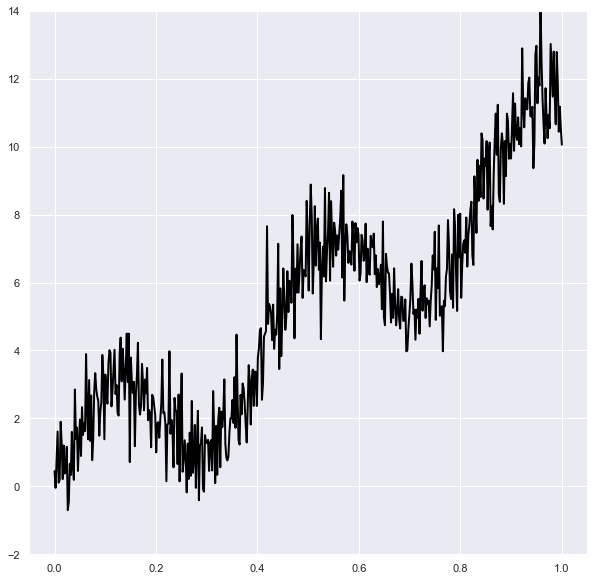

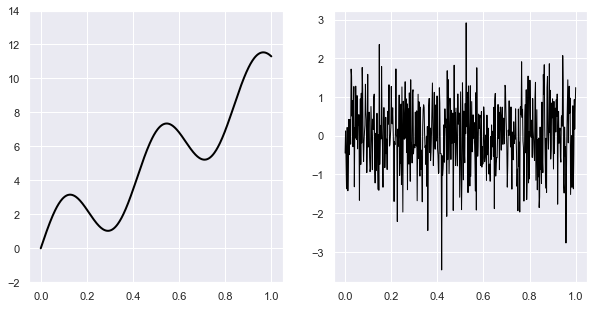

In [16]:
(base_points_x, base_points_y) = build_base_curve(num_base_points, noise_scale, True)

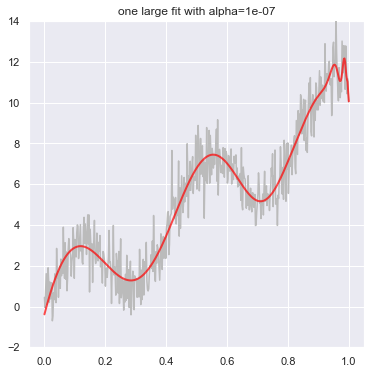

In [17]:
make_one_big_regression()

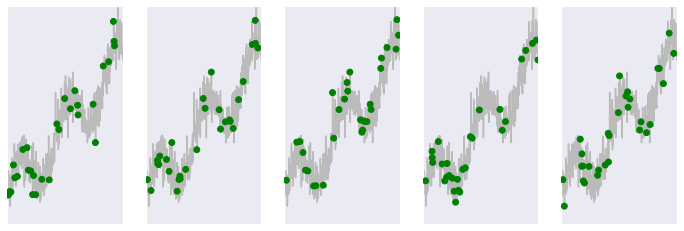

In [18]:
boot_list = build_bootstrap_list(base_points_y, num_bootstraps, pts_per_bootstrap, lock_down_ends)

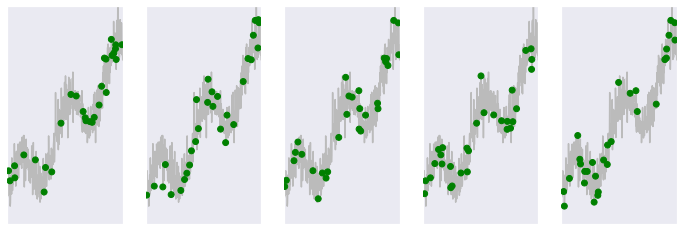

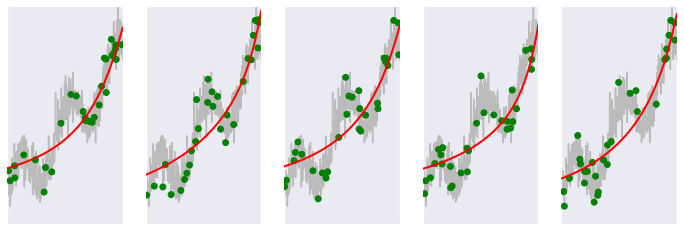

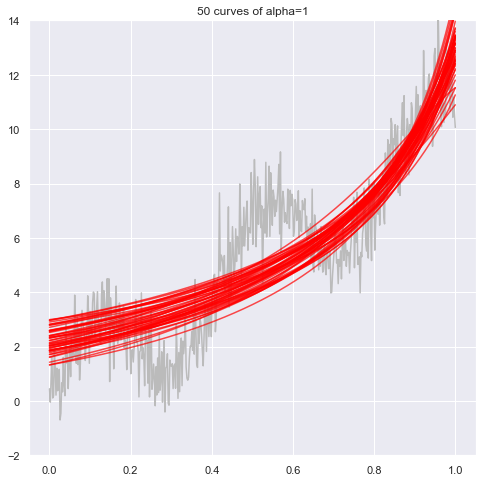

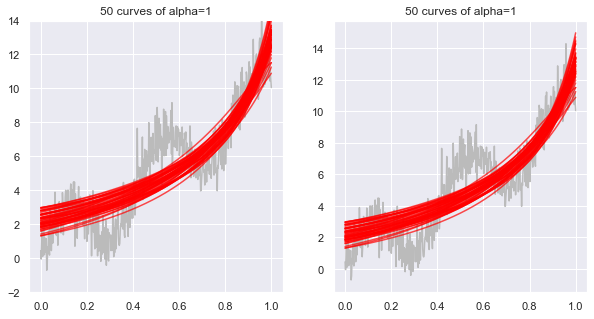

In [19]:
# Make the high-bias, low-variance bootstraps and show the results

alpha = 1
stats_list = []
boot_list = build_bootstrap_list(base_points_y, num_bootstraps, pts_per_bootstrap, lock_down_ends)
build_bootstrap_predictions(boot_list, alpha, degree)
show_fit_examples(boot_list)
show_overlaid_fits(boot_list, num_curves_to_show_overlapped)

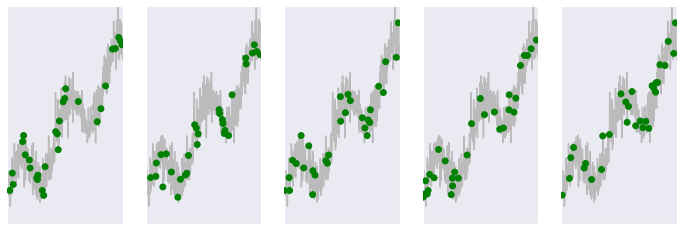

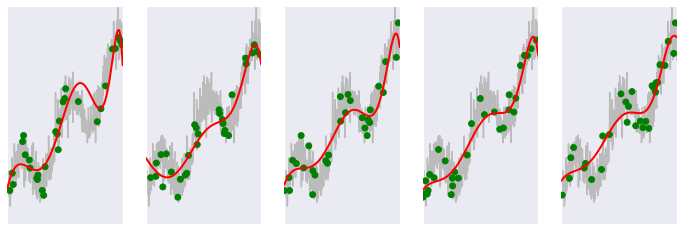

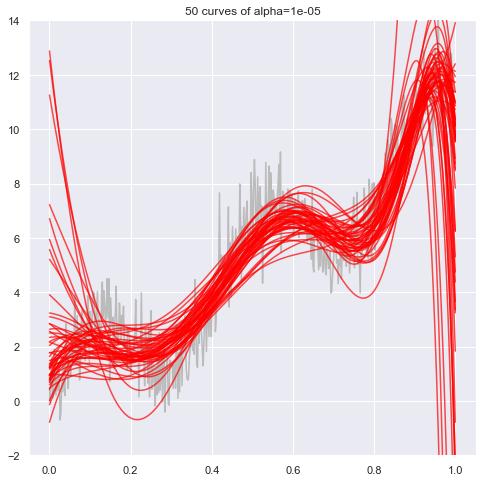

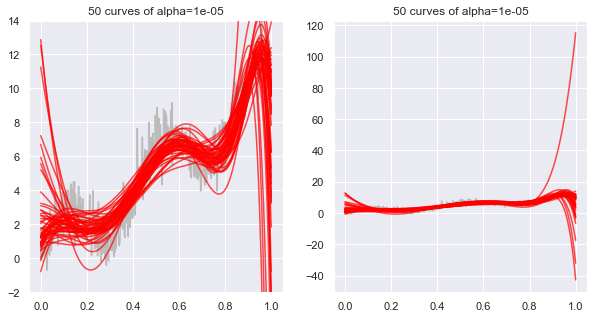

In [20]:
# Make the low-bias, high-variance bootstraps and show the results

alpha = 1e-5
stats_list = []
boot_list = build_bootstrap_list(base_points_y, num_bootstraps, pts_per_bootstrap, lock_down_ends)
build_bootstrap_predictions(boot_list, alpha, degree)
show_fit_examples(boot_list)
show_overlaid_fits(boot_list, num_curves_to_show_overlapped)